In [16]:
# !pip install --ignore-installed llvmlite
# pip install tsfeatures

In [18]:
# from tsfeatures import tsfeatures as tf
# from tsfeatures import acf_features

# acf = acf_features(amp)
# print(acf)

{'x_acf1': 0.9999582361782643, 'x_acf10': 9.994284969266813, 'diff1_acf1': 0.04133651174934224, 'diff1_acf10': 0.016496135313006394, 'diff2_acf1': -0.4999198686030941, 'diff2_acf10': 0.24991987504080515}


In [158]:
import numpy as np

file_path = 'data/week8/40 Second Data/1504lookright40seconds.csv'

with open(file_path, 'r') as file:
    csv_content = file.readlines()

Time = [float(line.split(',')[0]) for line in csv_content]
amp = [float(line.split(',')[1]) for line in csv_content]

time = np.array(Time)
amp_array = np.array(amp)

time[:5], amp[:5]

(array([0.        , 0.00010002, 0.00020004, 0.00030006, 0.00040008]),
 [513.2606409956952,
  513.2573874276039,
  513.2538033920101,
  513.2498809053178,
  513.2456118158696])

Test statistics: [20. 21. 21. ... 16. 16. 16.]


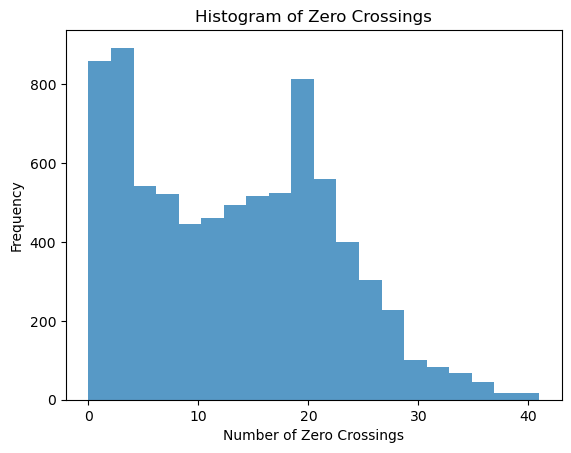

Predicted events: [False False False ... False False False]
{'num_event': 18, 'predictedEventTimes': array([False, False, False, ..., False, False, False]), 'predictedInterval': array([[ 0.93013773,  3.56567142],
       [ 4.92594688,  5.23600967],
       [ 6.54127398,  8.57168514],
       [ 9.32183705,  9.71691705],
       [10.37204972, 10.37204972],
       [10.93216314, 13.89776367],
       [14.98298343, 15.23303406],
       [16.49829028, 18.49369435],
       [19.18883511, 19.52390297],
       [21.10922399, 21.21924627],
       [22.52451059, 22.8445754 ],
       [23.41969186, 25.69015163],
       [28.81078356, 28.93580888],
       [29.52592838, 31.61635169],
       [35.01704033, 36.90742313],
       [37.58756086, 37.83261048],
       [38.6277715 , 38.70278669],
       [39.30790923, 39.67298315]])}


In [166]:
import matplotlib.pyplot as plt

def eye_movement_ZC(Y, time, windowSize=0.5, percentile=45, downSampleRate=50):
    
    time_max = time.max()
    ind = np.where(time <= time_max - windowSize)[0][-1]  
    ind = np.arange(0, ind + 1, downSampleRate)

    timeMiddle = time[ind] + windowSize / 2
    testStat = np.zeros(len(ind))
    
    Y_mean = np.mean(Y)
    Y = Y - Y_mean
    
    for i, idx in enumerate(ind):
        window_mask = (time >= time[idx]) & (time < time[idx] + windowSize)
        Y_subset = Y[window_mask]

        zero_crossings = np.sum(np.diff(np.sign(Y_subset)) != 0)
        testStat[i] = zero_crossings
    
    thresholdEvents = np.percentile(testStat, percentile)
    predictedEvent = testStat < thresholdEvents
    eventTimes = timeMiddle[predictedEvent]
    
    print("Test statistics:", testStat)
    plt.hist(testStat, bins=20, alpha=0.75)
    plt.title('Histogram of Zero Crossings')
    plt.xlabel('Number of Zero Crossings')
    plt.ylabel('Frequency')
    plt.show()
    print("Predicted events:", predictedEvent)
    
    
    gaps = np.where(np.diff(eventTimes) > windowSize)[0]
    event_time_interval = [eventTimes[0]]
    
    for gap in gaps:
        event_time_interval.extend([eventTimes[gap], eventTimes[gap+1]])
        
    event_time_interval.append(eventTimes[-1])
    event_time_interval = np.array(event_time_interval).reshape(-1, 2)
    
    predictedEventTimes = np.zeros(len(Y), dtype=bool)
    for start, end in event_time_interval:
        predictedEventTimes[(time >= start) & (time <= end)] = True
        
    num_event = len(gaps) + 1

    
    return {
        'num_event': num_event, 
        'predictedEventTimes': predictedEventTimes,
        'predictedInterval': event_time_interval
    }

testSta = []
eye_movement_results = eye_movement_ZC(amp, time)
print(eye_movement_results)




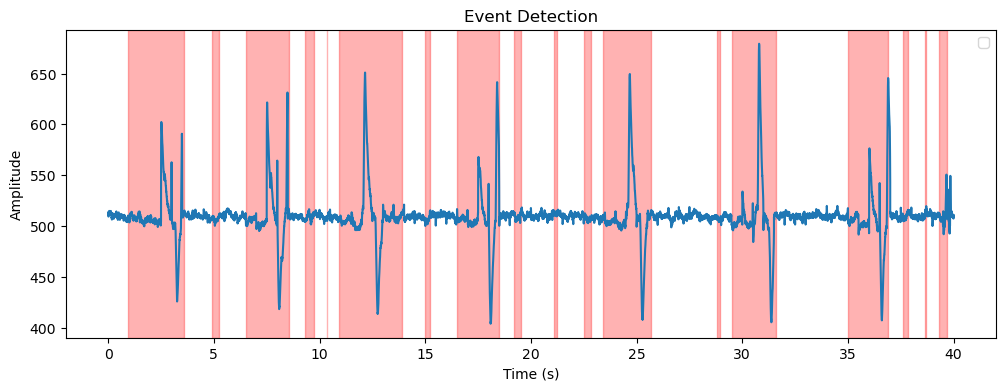

In [167]:
plt.figure(figsize=(12, 4))
plt.plot(time, amp)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Event Detection')

event_intervals = eye_movement_results['predictedInterval']
for interval in event_intervals:
    start, end = interval

    plt.axvspan(start, end, color='red', alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [106]:
def extract_laps(laps_data, name):
    lines = laps_data.strip().split("\n")
    laps = []
    found = False
    for line in lines:
        line = line.strip()
        if not line:
            pass
        elif not line.replace(".", "").isnumeric():
            if found:
                break
            if name == line:
                found = True
        elif found:
            laps.append(float(line))
    laps = np.cumsum(np.array(laps))
    return laps

# laps_txt_path = 'data/week6/laps.txt'
# with open(laps_txt_path, 'r') as file:
#     laps_file_content = file.read()

# laps = extract_laps(laps_file_content, '40secondlookrightlaps')
# laps


In [168]:
def extractSignal(event_intervals, min_time_range = 0.6):
    durations = event_intervals[:, 1] - event_intervals[:, 0]

    filtered_intervals = event_intervals[durations >= min_time_range]
    return filtered_intervals

filtered_intervals = extractSignal(eye_movement_results['predictedInterval'])
filtered_intervals

array([[ 0.93013773,  3.56567142],
       [ 6.54127398,  8.57168514],
       [10.93216314, 13.89776367],
       [16.49829028, 18.49369435],
       [23.41969186, 25.69015163],
       [29.52592838, 31.61635169],
       [35.01704033, 36.90742313]])

In [154]:
def get_index(time_point):
    i = 0
    while (i < len(time)):

        if (time[i] >= time_point):
            return i
        i += 1
    return len(time) - 1


def LR_detection(event_intervals):
    movements = []
    i = 0
    while (i < len(reversed_intervals)):
        start_index = get_index(reversed_intervals[i][0])
        end_index = get_index(reversed_intervals[i][1])
        
        event_values = amp_reversed[start_index:end_index]
        
        max_index = event_values.index(min(event_values))
        min_index = event_values.index(max(event_values))
        
        if (max_index > min_index):
            movement = "L"
        else:
            movement = 'R'
        movements.append(movement)
        i = i + 1
        
    return movements

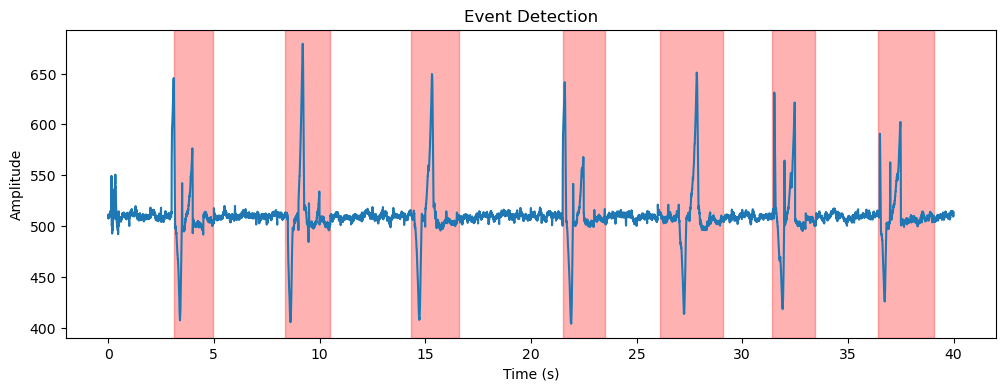

['L', 'R', 'R', 'L', 'R', 'L', 'R']


In [169]:
def plot_data(time, amp, laps=None, event_intervals=None, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(time, amp)
    if laps is not None:
        ax.vlines(laps, np.min(amp), np.max(amp), color="red")
    if event_intervals is not None:
        for start, end in event_intervals:
            ax.axvspan(start, end, color='red', alpha=0.3)

amp_reversed = amp[::-1]

max_time = np.max(time)
reversed_intervals = [(max_time - end, max_time - start) for start, end in filtered_intervals]
reversed_intervals.sort()

plt.figure(figsize=(12, 4))
plot_data(time, amp_reversed, event_intervals=reversed_intervals)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Event Detection')
plt.show()
print(LR_detection(reversed_intervals))